In [72]:
TRAIN_FRAC = 0.95
VALIDATION_FRAC = 0.1 # fraction of TRAIN_FRAC to use as validation set when training

In [73]:
import glob

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow_model_optimization.quantization.keras import quantize_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

In [82]:
MAX_DISTANCE = 400
MAX_SIGMA = 10

AUGMENT_COUNT = 1000
AUGMENT_DELTA_RANGE = 10

def load_data(paths):
    if isinstance(paths, str):
        paths = [paths]

    df = pd.concat([pd.read_csv(p) for p in paths])
    df.reset_index(drop=True, inplace=True)
    
    labels = df.loc[:, "symbol"].to_numpy()
    distances = df.loc[:, "dist(0,0)":"dist(7,7)"].to_numpy().reshape((-1, 8, 8, 1))
    sigma = df.loc[:, "sigma(0,0)":"sigma(7,7)"].to_numpy().reshape((-1, 8, 8, 1))
    
    distances = distances.clip(max=MAX_DISTANCE) / MAX_DISTANCE
    sigma = sigma.clip(max=MAX_SIGMA) / MAX_SIGMA
    
    aug_indices = np.random.permutation(distances.shape[0])[:AUGMENT_COUNT]
    aug_labels = labels[aug_indices]
    aug_distances = distances[aug_indices, :].copy()
    aug_sigma = sigma[aug_indices, :]
    
    # Shift to/away
    shift = (np.random.randint(-AUGMENT_DELTA_RANGE, AUGMENT_DELTA_RANGE, size=aug_distances.shape[0]) / MAX_DISTANCE).repeat(64).reshape((-1, 8, 8, 1))
    aug_distances += shift
    
    labels = np.concatenate((labels, aug_labels))
    distances = np.concatenate((distances, aug_distances))
    sigma = np.concatenate((sigma, aug_sigma))
    
    inputs = np.concatenate((distances, sigma), axis=-1)
    
    return inputs, labels
    
paths = glob.glob("data/right_sl_sharp_sigma_far*.csv")
print(f"Loading data from {', '.join(paths)}")
x, y = load_data(paths)

data_train, data_test, labels_train, labels_test = train_test_split(x, y, train_size=TRAIN_FRAC, random_state=0)

print(f"Class counts: {dict(zip(*np.unique(labels_test, return_counts=True)))}")

print(f"train: {len(data_train)} test: {len(data_test)}")

Loading data from data/right_sl_sharp_sigma_far_tilt_2022-04-06T07-24-52.csv, data/right_sl_sharp_sigma_far_2022-04-05T16-44-08.csv, data/right_sl_sharp_sigma_far_2022-04-05T16-19-31.csv
Class counts: {0: 28, 1: 30, 2: 23, 3: 37, 4: 29, 5: 22, 6: 21, 7: 22, 8: 25, 9: 25}
train: 4970 test: 262


In [84]:
NUM_CLASSES = 10
IMAGE_SIZE = 8

model = tf.keras.Sequential([
    layers.Conv2D(16, 3, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 2)),.u
    layers.ReLU(),
    layers.MaxPooling2D(),
    layers.Dropout(rate=0.25),
    layers.Flatten(),
    layers.Dense(16, activation="relu"),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

model.summary()

q_aware_model = quantize_model(model)
# q_aware_model = model
q_aware_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = q_aware_model.fit(data_train, labels_train, epochs=1024, batch_size=16, validation_split=VALIDATION_FRAC, verbose=2)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 6, 6, 16)          304       
                                                                 
 re_lu_20 (ReLU)             (None, 6, 6, 16)          0         
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 3, 3, 16)         0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 3, 3, 16)          0         
                                                                 
 flatten_17 (Flatten)        (None, 144)               0         
                                                                 
 dense_34 (Dense)            (None, 16)                2320      
                                                     

Epoch 55/1024
280/280 - 1s - loss: 0.0686 - accuracy: 0.9781 - val_loss: 0.0273 - val_accuracy: 0.9960 - 900ms/epoch - 3ms/step
Epoch 56/1024
280/280 - 1s - loss: 0.0636 - accuracy: 0.9788 - val_loss: 0.0232 - val_accuracy: 0.9980 - 718ms/epoch - 3ms/step
Epoch 57/1024
280/280 - 1s - loss: 0.0649 - accuracy: 0.9797 - val_loss: 0.0221 - val_accuracy: 0.9960 - 712ms/epoch - 3ms/step
Epoch 58/1024
280/280 - 1s - loss: 0.0635 - accuracy: 0.9776 - val_loss: 0.0179 - val_accuracy: 0.9980 - 723ms/epoch - 3ms/step
Epoch 59/1024
280/280 - 1s - loss: 0.0629 - accuracy: 0.9783 - val_loss: 0.0235 - val_accuracy: 0.9980 - 721ms/epoch - 3ms/step
Epoch 60/1024
280/280 - 1s - loss: 0.0678 - accuracy: 0.9799 - val_loss: 0.0221 - val_accuracy: 0.9960 - 713ms/epoch - 3ms/step
Epoch 61/1024
280/280 - 1s - loss: 0.0621 - accuracy: 0.9841 - val_loss: 0.0176 - val_accuracy: 0.9980 - 729ms/epoch - 3ms/step
Epoch 62/1024
280/280 - 1s - loss: 0.0629 - accuracy: 0.9801 - val_loss: 0.0189 - val_accuracy: 0.9980 -

Epoch 119/1024
280/280 - 1s - loss: 0.0375 - accuracy: 0.9888 - val_loss: 0.0084 - val_accuracy: 0.9980 - 777ms/epoch - 3ms/step
Epoch 120/1024
280/280 - 1s - loss: 0.0279 - accuracy: 0.9899 - val_loss: 0.0083 - val_accuracy: 0.9980 - 782ms/epoch - 3ms/step
Epoch 121/1024
280/280 - 1s - loss: 0.0404 - accuracy: 0.9866 - val_loss: 0.0063 - val_accuracy: 0.9980 - 729ms/epoch - 3ms/step
Epoch 122/1024
280/280 - 1s - loss: 0.0333 - accuracy: 0.9890 - val_loss: 0.0096 - val_accuracy: 0.9980 - 725ms/epoch - 3ms/step
Epoch 123/1024
280/280 - 1s - loss: 0.0350 - accuracy: 0.9893 - val_loss: 0.0083 - val_accuracy: 0.9980 - 715ms/epoch - 3ms/step
Epoch 124/1024
280/280 - 1s - loss: 0.0322 - accuracy: 0.9879 - val_loss: 0.0079 - val_accuracy: 0.9980 - 726ms/epoch - 3ms/step
Epoch 125/1024
280/280 - 1s - loss: 0.0319 - accuracy: 0.9890 - val_loss: 0.0089 - val_accuracy: 0.9980 - 716ms/epoch - 3ms/step
Epoch 126/1024
280/280 - 1s - loss: 0.0325 - accuracy: 0.9906 - val_loss: 0.0060 - val_accuracy: 

Epoch 183/1024
280/280 - 1s - loss: 0.0213 - accuracy: 0.9937 - val_loss: 0.0040 - val_accuracy: 0.9980 - 1s/epoch - 4ms/step
Epoch 184/1024
280/280 - 1s - loss: 0.0201 - accuracy: 0.9937 - val_loss: 0.0097 - val_accuracy: 0.9960 - 1s/epoch - 4ms/step
Epoch 185/1024
280/280 - 1s - loss: 0.0231 - accuracy: 0.9926 - val_loss: 0.0061 - val_accuracy: 0.9980 - 840ms/epoch - 3ms/step
Epoch 186/1024
280/280 - 1s - loss: 0.0240 - accuracy: 0.9922 - val_loss: 0.0072 - val_accuracy: 0.9960 - 900ms/epoch - 3ms/step
Epoch 187/1024
280/280 - 1s - loss: 0.0253 - accuracy: 0.9911 - val_loss: 0.0065 - val_accuracy: 0.9980 - 981ms/epoch - 4ms/step
Epoch 188/1024
280/280 - 1s - loss: 0.0263 - accuracy: 0.9908 - val_loss: 0.0058 - val_accuracy: 0.9960 - 925ms/epoch - 3ms/step
Epoch 189/1024
280/280 - 1s - loss: 0.0248 - accuracy: 0.9906 - val_loss: 0.0068 - val_accuracy: 0.9980 - 736ms/epoch - 3ms/step
Epoch 190/1024
280/280 - 1s - loss: 0.0226 - accuracy: 0.9915 - val_loss: 0.0031 - val_accuracy: 0.9980

Epoch 247/1024
280/280 - 1s - loss: 0.0215 - accuracy: 0.9926 - val_loss: 0.0104 - val_accuracy: 0.9960 - 1s/epoch - 4ms/step
Epoch 248/1024
280/280 - 1s - loss: 0.0231 - accuracy: 0.9924 - val_loss: 0.0095 - val_accuracy: 0.9960 - 1s/epoch - 4ms/step
Epoch 249/1024
280/280 - 1s - loss: 0.0193 - accuracy: 0.9935 - val_loss: 0.0057 - val_accuracy: 0.9960 - 1s/epoch - 4ms/step
Epoch 250/1024
280/280 - 1s - loss: 0.0208 - accuracy: 0.9935 - val_loss: 0.0075 - val_accuracy: 0.9960 - 990ms/epoch - 4ms/step
Epoch 251/1024
280/280 - 1s - loss: 0.0211 - accuracy: 0.9922 - val_loss: 0.0048 - val_accuracy: 0.9980 - 1s/epoch - 4ms/step
Epoch 252/1024
280/280 - 1s - loss: 0.0221 - accuracy: 0.9928 - val_loss: 0.0071 - val_accuracy: 0.9980 - 1s/epoch - 4ms/step
Epoch 253/1024
280/280 - 1s - loss: 0.0256 - accuracy: 0.9895 - val_loss: 0.0046 - val_accuracy: 0.9980 - 1s/epoch - 4ms/step
Epoch 254/1024
280/280 - 1s - loss: 0.0177 - accuracy: 0.9940 - val_loss: 0.0042 - val_accuracy: 0.9980 - 1s/epoch 

Epoch 311/1024
280/280 - 1s - loss: 0.0152 - accuracy: 0.9949 - val_loss: 0.0042 - val_accuracy: 0.9980 - 790ms/epoch - 3ms/step
Epoch 312/1024
280/280 - 1s - loss: 0.0167 - accuracy: 0.9955 - val_loss: 0.0120 - val_accuracy: 0.9920 - 717ms/epoch - 3ms/step
Epoch 313/1024
280/280 - 1s - loss: 0.0163 - accuracy: 0.9946 - val_loss: 0.0091 - val_accuracy: 0.9980 - 731ms/epoch - 3ms/step
Epoch 314/1024
280/280 - 1s - loss: 0.0106 - accuracy: 0.9964 - val_loss: 0.0027 - val_accuracy: 0.9980 - 733ms/epoch - 3ms/step
Epoch 315/1024
280/280 - 1s - loss: 0.0174 - accuracy: 0.9951 - val_loss: 0.0041 - val_accuracy: 0.9980 - 806ms/epoch - 3ms/step
Epoch 316/1024
280/280 - 1s - loss: 0.0196 - accuracy: 0.9935 - val_loss: 0.0073 - val_accuracy: 0.9980 - 909ms/epoch - 3ms/step
Epoch 317/1024
280/280 - 1s - loss: 0.0148 - accuracy: 0.9953 - val_loss: 0.0099 - val_accuracy: 0.9980 - 859ms/epoch - 3ms/step
Epoch 318/1024
280/280 - 1s - loss: 0.0123 - accuracy: 0.9960 - val_loss: 0.0039 - val_accuracy: 

Epoch 375/1024
280/280 - 1s - loss: 0.0127 - accuracy: 0.9955 - val_loss: 0.0033 - val_accuracy: 0.9980 - 802ms/epoch - 3ms/step
Epoch 376/1024
280/280 - 1s - loss: 0.0142 - accuracy: 0.9944 - val_loss: 0.0032 - val_accuracy: 1.0000 - 767ms/epoch - 3ms/step
Epoch 377/1024
280/280 - 1s - loss: 0.0101 - accuracy: 0.9964 - val_loss: 0.0059 - val_accuracy: 0.9980 - 745ms/epoch - 3ms/step
Epoch 378/1024
280/280 - 1s - loss: 0.0120 - accuracy: 0.9964 - val_loss: 0.0040 - val_accuracy: 0.9980 - 714ms/epoch - 3ms/step
Epoch 379/1024
280/280 - 1s - loss: 0.0142 - accuracy: 0.9940 - val_loss: 0.0012 - val_accuracy: 1.0000 - 719ms/epoch - 3ms/step
Epoch 380/1024
280/280 - 1s - loss: 0.0100 - accuracy: 0.9962 - val_loss: 0.0018 - val_accuracy: 1.0000 - 721ms/epoch - 3ms/step
Epoch 381/1024
280/280 - 1s - loss: 0.0160 - accuracy: 0.9949 - val_loss: 0.0029 - val_accuracy: 1.0000 - 735ms/epoch - 3ms/step
Epoch 382/1024
280/280 - 1s - loss: 0.0124 - accuracy: 0.9962 - val_loss: 0.0041 - val_accuracy: 

Epoch 439/1024
280/280 - 1s - loss: 0.0166 - accuracy: 0.9946 - val_loss: 0.0024 - val_accuracy: 0.9980 - 723ms/epoch - 3ms/step
Epoch 440/1024
280/280 - 1s - loss: 0.0130 - accuracy: 0.9962 - val_loss: 6.0437e-04 - val_accuracy: 1.0000 - 745ms/epoch - 3ms/step
Epoch 441/1024
280/280 - 1s - loss: 0.0183 - accuracy: 0.9958 - val_loss: 0.0022 - val_accuracy: 0.9980 - 722ms/epoch - 3ms/step
Epoch 442/1024
280/280 - 1s - loss: 0.0134 - accuracy: 0.9960 - val_loss: 0.0041 - val_accuracy: 0.9980 - 718ms/epoch - 3ms/step
Epoch 443/1024
280/280 - 1s - loss: 0.0086 - accuracy: 0.9973 - val_loss: 0.0015 - val_accuracy: 1.0000 - 727ms/epoch - 3ms/step
Epoch 444/1024
280/280 - 1s - loss: 0.0112 - accuracy: 0.9953 - val_loss: 0.0027 - val_accuracy: 0.9980 - 748ms/epoch - 3ms/step
Epoch 445/1024
280/280 - 1s - loss: 0.0144 - accuracy: 0.9946 - val_loss: 0.0071 - val_accuracy: 0.9980 - 722ms/epoch - 3ms/step
Epoch 446/1024
280/280 - 1s - loss: 0.0118 - accuracy: 0.9958 - val_loss: 0.0051 - val_accura

Epoch 503/1024
280/280 - 1s - loss: 0.0153 - accuracy: 0.9942 - val_loss: 0.0029 - val_accuracy: 1.0000 - 724ms/epoch - 3ms/step
Epoch 504/1024
280/280 - 1s - loss: 0.0176 - accuracy: 0.9937 - val_loss: 0.0048 - val_accuracy: 0.9980 - 714ms/epoch - 3ms/step
Epoch 505/1024
280/280 - 1s - loss: 0.0156 - accuracy: 0.9935 - val_loss: 0.0013 - val_accuracy: 1.0000 - 767ms/epoch - 3ms/step
Epoch 506/1024
280/280 - 1s - loss: 0.0144 - accuracy: 0.9949 - val_loss: 0.0051 - val_accuracy: 0.9960 - 776ms/epoch - 3ms/step
Epoch 507/1024
280/280 - 1s - loss: 0.0131 - accuracy: 0.9960 - val_loss: 0.0032 - val_accuracy: 0.9980 - 796ms/epoch - 3ms/step
Epoch 508/1024
280/280 - 1s - loss: 0.0132 - accuracy: 0.9955 - val_loss: 0.0047 - val_accuracy: 0.9960 - 751ms/epoch - 3ms/step
Epoch 509/1024
280/280 - 1s - loss: 0.0145 - accuracy: 0.9955 - val_loss: 9.8910e-04 - val_accuracy: 1.0000 - 751ms/epoch - 3ms/step
Epoch 510/1024
280/280 - 1s - loss: 0.0143 - accuracy: 0.9946 - val_loss: 0.0011 - val_accura

Epoch 567/1024
280/280 - 1s - loss: 0.0171 - accuracy: 0.9944 - val_loss: 4.2285e-04 - val_accuracy: 1.0000 - 717ms/epoch - 3ms/step
Epoch 568/1024
280/280 - 1s - loss: 0.0100 - accuracy: 0.9969 - val_loss: 0.0035 - val_accuracy: 0.9980 - 714ms/epoch - 3ms/step
Epoch 569/1024
280/280 - 1s - loss: 0.0165 - accuracy: 0.9955 - val_loss: 0.0057 - val_accuracy: 0.9980 - 725ms/epoch - 3ms/step
Epoch 570/1024
280/280 - 1s - loss: 0.0112 - accuracy: 0.9962 - val_loss: 0.0052 - val_accuracy: 0.9980 - 718ms/epoch - 3ms/step
Epoch 571/1024
280/280 - 1s - loss: 0.0094 - accuracy: 0.9971 - val_loss: 0.0034 - val_accuracy: 0.9980 - 724ms/epoch - 3ms/step
Epoch 572/1024
280/280 - 1s - loss: 0.0099 - accuracy: 0.9964 - val_loss: 0.0027 - val_accuracy: 0.9980 - 746ms/epoch - 3ms/step
Epoch 573/1024
280/280 - 1s - loss: 0.0106 - accuracy: 0.9960 - val_loss: 0.0082 - val_accuracy: 0.9980 - 745ms/epoch - 3ms/step
Epoch 574/1024
280/280 - 1s - loss: 0.0120 - accuracy: 0.9955 - val_loss: 0.0048 - val_accura

Epoch 631/1024
280/280 - 1s - loss: 0.0121 - accuracy: 0.9962 - val_loss: 7.2551e-04 - val_accuracy: 1.0000 - 723ms/epoch - 3ms/step
Epoch 632/1024
280/280 - 1s - loss: 0.0147 - accuracy: 0.9953 - val_loss: 9.7466e-04 - val_accuracy: 1.0000 - 728ms/epoch - 3ms/step
Epoch 633/1024
280/280 - 1s - loss: 0.0142 - accuracy: 0.9946 - val_loss: 0.0028 - val_accuracy: 1.0000 - 722ms/epoch - 3ms/step
Epoch 634/1024
280/280 - 1s - loss: 0.0173 - accuracy: 0.9937 - val_loss: 0.0049 - val_accuracy: 0.9980 - 731ms/epoch - 3ms/step
Epoch 635/1024
280/280 - 1s - loss: 0.0085 - accuracy: 0.9966 - val_loss: 0.0022 - val_accuracy: 0.9980 - 721ms/epoch - 3ms/step
Epoch 636/1024
280/280 - 1s - loss: 0.0105 - accuracy: 0.9966 - val_loss: 9.5922e-04 - val_accuracy: 1.0000 - 721ms/epoch - 3ms/step
Epoch 637/1024
280/280 - 1s - loss: 0.0106 - accuracy: 0.9969 - val_loss: 0.0019 - val_accuracy: 0.9980 - 715ms/epoch - 3ms/step
Epoch 638/1024
280/280 - 1s - loss: 0.0068 - accuracy: 0.9973 - val_loss: 0.0050 - va

Epoch 695/1024
280/280 - 1s - loss: 0.0091 - accuracy: 0.9973 - val_loss: 0.0026 - val_accuracy: 0.9980 - 721ms/epoch - 3ms/step
Epoch 696/1024
280/280 - 1s - loss: 0.0060 - accuracy: 0.9978 - val_loss: 0.0013 - val_accuracy: 1.0000 - 772ms/epoch - 3ms/step
Epoch 697/1024
280/280 - 1s - loss: 0.0113 - accuracy: 0.9964 - val_loss: 0.0022 - val_accuracy: 0.9980 - 717ms/epoch - 3ms/step
Epoch 698/1024
280/280 - 1s - loss: 0.0083 - accuracy: 0.9975 - val_loss: 0.0047 - val_accuracy: 0.9980 - 728ms/epoch - 3ms/step
Epoch 699/1024
280/280 - 1s - loss: 0.0139 - accuracy: 0.9955 - val_loss: 9.6088e-04 - val_accuracy: 1.0000 - 721ms/epoch - 3ms/step
Epoch 700/1024
280/280 - 1s - loss: 0.0127 - accuracy: 0.9964 - val_loss: 9.6182e-04 - val_accuracy: 1.0000 - 734ms/epoch - 3ms/step
Epoch 701/1024
280/280 - 1s - loss: 0.0157 - accuracy: 0.9949 - val_loss: 0.0030 - val_accuracy: 0.9980 - 713ms/epoch - 3ms/step
Epoch 702/1024
280/280 - 1s - loss: 0.0112 - accuracy: 0.9962 - val_loss: 0.0012 - val_ac

Epoch 759/1024
280/280 - 1s - loss: 0.0107 - accuracy: 0.9962 - val_loss: 0.0074 - val_accuracy: 0.9980 - 796ms/epoch - 3ms/step
Epoch 760/1024
280/280 - 1s - loss: 0.0148 - accuracy: 0.9949 - val_loss: 7.4739e-04 - val_accuracy: 1.0000 - 884ms/epoch - 3ms/step
Epoch 761/1024
280/280 - 1s - loss: 0.0113 - accuracy: 0.9969 - val_loss: 0.0035 - val_accuracy: 0.9960 - 862ms/epoch - 3ms/step
Epoch 762/1024
280/280 - 1s - loss: 0.0092 - accuracy: 0.9971 - val_loss: 0.0022 - val_accuracy: 0.9980 - 897ms/epoch - 3ms/step
Epoch 763/1024
280/280 - 1s - loss: 0.0121 - accuracy: 0.9966 - val_loss: 0.0012 - val_accuracy: 1.0000 - 972ms/epoch - 3ms/step
Epoch 764/1024
280/280 - 1s - loss: 0.0095 - accuracy: 0.9964 - val_loss: 7.9520e-04 - val_accuracy: 1.0000 - 935ms/epoch - 3ms/step
Epoch 765/1024
280/280 - 1s - loss: 0.0106 - accuracy: 0.9953 - val_loss: 0.0061 - val_accuracy: 0.9980 - 738ms/epoch - 3ms/step
Epoch 766/1024
280/280 - 1s - loss: 0.0149 - accuracy: 0.9962 - val_loss: 0.0029 - val_ac

Epoch 823/1024
280/280 - 1s - loss: 0.0090 - accuracy: 0.9971 - val_loss: 0.0061 - val_accuracy: 0.9980 - 747ms/epoch - 3ms/step
Epoch 824/1024
280/280 - 1s - loss: 0.0071 - accuracy: 0.9975 - val_loss: 0.0011 - val_accuracy: 1.0000 - 718ms/epoch - 3ms/step
Epoch 825/1024
280/280 - 1s - loss: 0.0096 - accuracy: 0.9969 - val_loss: 0.0020 - val_accuracy: 0.9980 - 734ms/epoch - 3ms/step
Epoch 826/1024
280/280 - 1s - loss: 0.0064 - accuracy: 0.9973 - val_loss: 0.0052 - val_accuracy: 0.9960 - 718ms/epoch - 3ms/step
Epoch 827/1024
280/280 - 1s - loss: 0.0107 - accuracy: 0.9960 - val_loss: 0.0056 - val_accuracy: 0.9980 - 731ms/epoch - 3ms/step
Epoch 828/1024
280/280 - 1s - loss: 0.0102 - accuracy: 0.9969 - val_loss: 0.0117 - val_accuracy: 0.9980 - 753ms/epoch - 3ms/step
Epoch 829/1024
280/280 - 1s - loss: 0.0090 - accuracy: 0.9969 - val_loss: 0.0109 - val_accuracy: 0.9980 - 727ms/epoch - 3ms/step
Epoch 830/1024
280/280 - 1s - loss: 0.0149 - accuracy: 0.9955 - val_loss: 0.0097 - val_accuracy: 

280/280 - 1s - loss: 0.0130 - accuracy: 0.9962 - val_loss: 0.0031 - val_accuracy: 0.9980 - 787ms/epoch - 3ms/step
Epoch 887/1024
280/280 - 1s - loss: 0.0099 - accuracy: 0.9958 - val_loss: 7.2718e-04 - val_accuracy: 1.0000 - 811ms/epoch - 3ms/step
Epoch 888/1024
280/280 - 1s - loss: 0.0053 - accuracy: 0.9982 - val_loss: 0.0040 - val_accuracy: 0.9980 - 801ms/epoch - 3ms/step
Epoch 889/1024
280/280 - 1s - loss: 0.0064 - accuracy: 0.9975 - val_loss: 0.0022 - val_accuracy: 0.9980 - 815ms/epoch - 3ms/step
Epoch 890/1024
280/280 - 1s - loss: 0.0070 - accuracy: 0.9973 - val_loss: 7.0379e-04 - val_accuracy: 1.0000 - 785ms/epoch - 3ms/step
Epoch 891/1024
280/280 - 1s - loss: 0.0097 - accuracy: 0.9964 - val_loss: 0.0080 - val_accuracy: 0.9980 - 755ms/epoch - 3ms/step
Epoch 892/1024
280/280 - 1s - loss: 0.0089 - accuracy: 0.9969 - val_loss: 0.0062 - val_accuracy: 0.9980 - 809ms/epoch - 3ms/step
Epoch 893/1024
280/280 - 1s - loss: 0.0052 - accuracy: 0.9984 - val_loss: 0.0011 - val_accuracy: 1.0000 

Epoch 949/1024
280/280 - 1s - loss: 0.0095 - accuracy: 0.9973 - val_loss: 0.0060 - val_accuracy: 0.9980 - 776ms/epoch - 3ms/step
Epoch 950/1024
280/280 - 1s - loss: 0.0089 - accuracy: 0.9975 - val_loss: 0.0095 - val_accuracy: 0.9980 - 715ms/epoch - 3ms/step
Epoch 951/1024
280/280 - 1s - loss: 0.0113 - accuracy: 0.9966 - val_loss: 0.0041 - val_accuracy: 0.9980 - 730ms/epoch - 3ms/step
Epoch 952/1024
280/280 - 1s - loss: 0.0099 - accuracy: 0.9971 - val_loss: 0.0033 - val_accuracy: 0.9980 - 726ms/epoch - 3ms/step
Epoch 953/1024
280/280 - 1s - loss: 0.0083 - accuracy: 0.9971 - val_loss: 0.0032 - val_accuracy: 0.9980 - 733ms/epoch - 3ms/step
Epoch 954/1024
280/280 - 1s - loss: 0.0149 - accuracy: 0.9962 - val_loss: 0.0027 - val_accuracy: 0.9980 - 730ms/epoch - 3ms/step
Epoch 955/1024
280/280 - 1s - loss: 0.0067 - accuracy: 0.9980 - val_loss: 0.0074 - val_accuracy: 0.9980 - 728ms/epoch - 3ms/step
Epoch 956/1024
280/280 - 1s - loss: 0.0043 - accuracy: 0.9978 - val_loss: 0.0069 - val_accuracy: 

Epoch 1012/1024
280/280 - 1s - loss: 0.0093 - accuracy: 0.9969 - val_loss: 5.5279e-04 - val_accuracy: 1.0000 - 732ms/epoch - 3ms/step
Epoch 1013/1024
280/280 - 1s - loss: 0.0069 - accuracy: 0.9973 - val_loss: 2.1375e-04 - val_accuracy: 1.0000 - 731ms/epoch - 3ms/step
Epoch 1014/1024
280/280 - 1s - loss: 0.0098 - accuracy: 0.9971 - val_loss: 6.4900e-04 - val_accuracy: 1.0000 - 817ms/epoch - 3ms/step
Epoch 1015/1024
280/280 - 1s - loss: 0.0147 - accuracy: 0.9962 - val_loss: 4.5366e-04 - val_accuracy: 1.0000 - 794ms/epoch - 3ms/step
Epoch 1016/1024
280/280 - 1s - loss: 0.0168 - accuracy: 0.9946 - val_loss: 9.8597e-04 - val_accuracy: 1.0000 - 765ms/epoch - 3ms/step
Epoch 1017/1024
280/280 - 1s - loss: 0.0077 - accuracy: 0.9978 - val_loss: 0.0024 - val_accuracy: 0.9980 - 712ms/epoch - 3ms/step
Epoch 1018/1024
280/280 - 1s - loss: 0.0081 - accuracy: 0.9969 - val_loss: 0.0022 - val_accuracy: 0.9980 - 721ms/epoch - 3ms/step
Epoch 1019/1024
280/280 - 1s - loss: 0.0104 - accuracy: 0.9953 - val_l

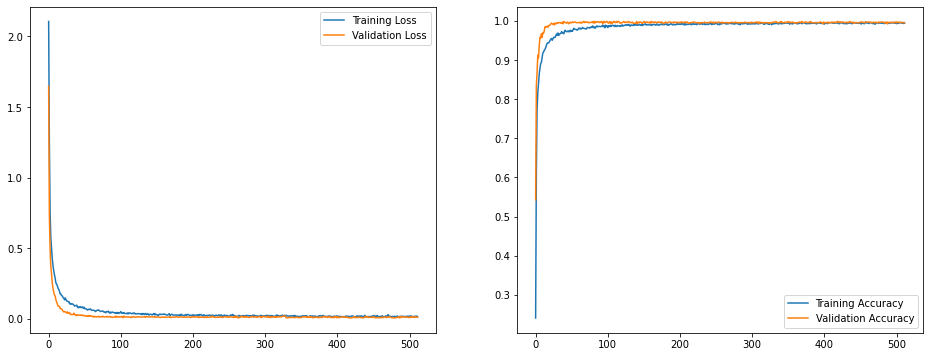

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(history.history["loss"], label="Training Loss")
axes[0].plot(history.history["val_loss"], label="Validation Loss")
axes[0].legend()

axes[1].plot(history.history["accuracy"], label="Training Accuracy")
axes[1].plot(history.history["val_accuracy"], label="Validation Accuracy")
axes[1].legend()
plt.show()

In [81]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

def representative_dataset_generator():
    for data in data_train:
        d = data.astype(np.float32).reshape(1, 8, 8, 1)
        yield [d]

converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.representative_dataset = representative_dataset_generator
                           
model_tflite = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(model_tflite)
                           
with open("number_model.h", "w") as f:
    f.write(hex_to_c_array(model_tflite, "number_model"))
    
display(f"{len(model_tflite)=}")

INFO:tensorflow:Assets written to: /tmp/tmppod6e5ev/assets


INFO:tensorflow:Assets written to: /tmp/tmppod6e5ev/assets
/opt/conda/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-04-06 16:22:06.448414: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-04-06 16:22:06.448488: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-04-06 16:22:06.448782: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmppod6e5ev
2022-04-06 16:22:06.454279: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-04-06 16:22:06.454334: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmppod6e5ev
2022-04-06 16:22:06.474768: I tensorflow/cc/saved_model/loader.cc:228] Rest

'len(model_tflite)=6920'

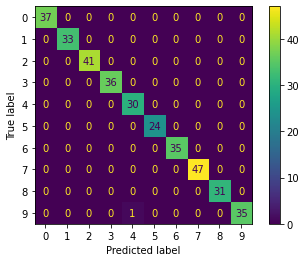

In [78]:
model_tfl = tf.lite.Interpreter("model.tflite")
model_tfl.allocate_tensors()

model_tfl_input_index = model_tfl.get_input_details()[0]["index"]
model_tfl_output_index = model_tfl.get_output_details()[0]["index"]

# y_full = model.predict(data_test).argmax(axis=1)
y_tflite = np.ndarray(len(data_test))
i = 0
for data in data_test:
    input_tensor = tf.convert_to_tensor([data], dtype=np.float32)
    model_tfl.set_tensor(model_tfl_input_index, input_tensor)
    model_tfl.invoke()
    y_tflite[i] = np.argmax(model_tfl.get_tensor(model_tfl_output_index))
    i += 1

ConfusionMatrixDisplay.from_predictions(y_true=labels_test, y_pred=y_tflite)
plt.show()